# Práctico: Recomendación de Artistas


Integrantes: 


*   **Lucas Lissandrelo   DNI:**
*   **Ivan Gutierrez      DNI: 33437838**

*   **Yirana Mejia        DNI: 95130042**



---


En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

In [ ]:
pip install surprise

     |████████████████████████████████| 11.8MB 5.1MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670904 sha256=0cf58fae406540183274c6f62d4629fbd24bcd178670e7cb4f82cc7550f4f400
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import seaborn as sns
from surprise import accuracy
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNWithMeans, SVD, NormalPredictor, KNNBasic, BaselineOnly, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate, train_test_split
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [ ]:
artist_url = 'https://raw.githubusercontent.com/lucaslissandrello/sistemas_de_recomendacion_trabajo_practico/main/data/lastfm/artists.dat'
artist_df = pd.read_csv(artist_url, sep="\t")
artist_df.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [ ]:
user_artist_plays_url = 'https://raw.githubusercontent.com/lucaslissandrello/sistemas_de_recomendacion_trabajo_practico/main/data/lastfm/user_artists.dat'
user_artist_plays_df = pd.read_csv(user_artist_plays_url, sep="\t")
user_artist_plays_df .head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [ ]:
tags_url = 'https://raw.githubusercontent.com/lucaslissandrello/sistemas_de_recomendacion_trabajo_practico/main/data/lastfm/tags.dat'
tags_df = pd.read_csv(tags_url, sep="\t", encoding = "latin-1'")
tags_df.head()

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [ ]:
user_tagged_artists_url = 'https://raw.githubusercontent.com/lucaslissandrello/sistemas_de_recomendacion_trabajo_practico/main/data/lastfm/user_taggedartists.dat'
user_tagged_artists_df = pd.read_csv(user_tagged_artists_url, sep="\t")
user_tagged_artists_df.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [ ]:
# General Functions
def normalize_data_frame(df, columns, max_value):
  data_frame = df[columns].copy()
  data
  scaler = preprocessing.MinMaxScaler()
  scaled_df = scaler.fit_transform(df.copy())
  scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'rating'])
  user_artist_plays_grouped_by_artist.weight = scaled_df.rating
  user_artist_plays_grouped_by_artist.columns = ['artistID', 'rating']

## Actividades

El [Ejercicio 1](#Ejercicio-1---Análisis-Exploratorio-de-Datos) deberá ser realizado por quienes estén realizando cualquier parte de la materia.

El [Ejercicio 2](#Ejercicio-2---Sistema-de-Recomendación) variará de acuerdo a que parte de la materia estén realizando, quienes estén realizando la materia completa, deberán realizar ambas partes.

De acuerdo a la parte de la materia que hagan, deberán realizar una de las siguientes actividades (pueden realizar ambas si así lo desean):

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar dos sistemas de recomendación: 
1. El primero, más sencillo, utilizando [Surpr!se](http://surpriselib.com/), y a partir de los datos de LastFM, en especial del archivo `./data/lastfm/user_artists.dat`, generar un sistema de recomendación basado en filtros colaborativos.
2. En el segundo, deberán utilizar todos los datos ofrecidos en el dataset de LastFM para generar un sistema de filtrado colaborativo más complejo, deberá utilizar las técnicas aprendidas 

basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

### Artistas más escuchados:

,name,weight
0,Britney Spears,2393140
1,Depeche Mode,1301308
2,Lady Gaga,1291387
3,Christina Aguilera,1058405
4,Paramore,963449


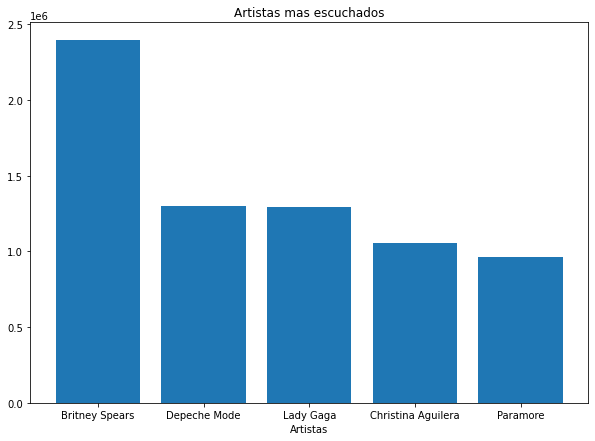

In [ ]:
artist_plays_df = user_artist_plays_df.groupby(['artistID'])[['weight']].sum().reset_index()

artist_plays_sorted_df = artist_plays_df.sort_values(by='weight', ascending=False).head()
artist_most_played = artist_plays_sorted_df.merge(artist_df, left_on='artistID', right_on='id')

fig = plt.figure(figsize = (10,7))
plt.bar(artist_most_played['name'], artist_most_played['weight'])
plt.xlabel('Artistas')
plt.title('Artistas mas escuchados')
plt.show
artist_most_played[['name','weight']]

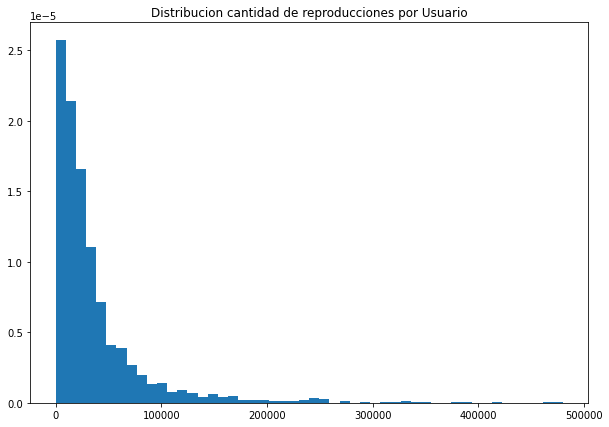

In [ ]:
artist_most_played = artist_plays_sorted_df.merge(artist_df, left_on='artistID', right_on='id')
user_artist_plays_grouped_by_userid= user_artist_plays_df.groupby(['userID'])[['weight']].sum()

fig = plt.figure(figsize = (10,7))
plt.hist(user_artist_plays_grouped_by_userid['weight'], 50, density=True)
plt.title('Distribucion cantidad de reproducciones por Usuario')
plt.show
plt.show()

#### Género más escuchado:

No es posible obtener el género más escuchado porque no es un metadato propio del aritista o del tema que escuchado. El genero es asignado por un usuario según su apreciación personal, este puede varia de acuerdo a su perspectiva personal. No es una propieda objetiva para artista, sino subjetiva.
Sin embargo, consideramos que con los datos que poseemos si podriamos inferir, cual es el genero de un artista, considerado por la mayoria de los usuarios. Incluso hacerlo por año.



,name,rating
0,Britney Spears,1.000000
1,Depeche Mode,0.543766
2,Lady Gaga,0.539620
3,Christina Aguilera,0.442266
4,Paramore,0.402588


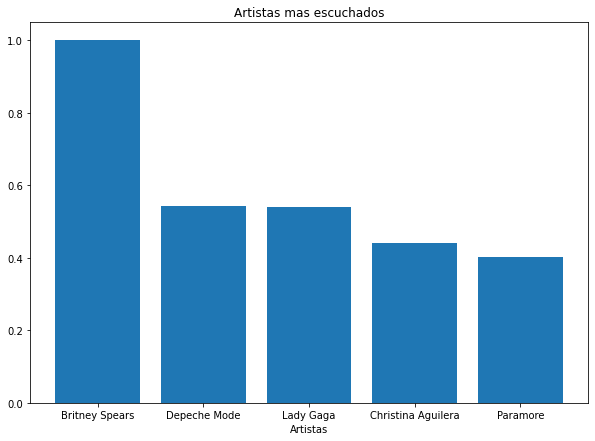

In [ ]:
user_artist_plays_grouped_by_artist_original= user_artist_plays.groupby(['artistID'])[['weight']].sum().reset_index()
#Normalize rating
scaler = preprocessing.MinMaxScaler()
scaled_df = scaler.fit_transform(user_artist_plays_grouped_by_artist.copy())
scaled_df = pd.DataFrame(scaled_df, columns=['x1', 'rating'])
user_artist_plays_grouped_by_artist.weight = scaled_df.rating
user_artist_plays_grouped_by_artist.columns = ['artistID', 'rating']

user_artist_plays_grouped_by_artist_ordered = user_artist_plays_grouped_by_artist.sort_values(by='rating', ascending=False).head()
artist_most_played = user_artist_plays_grouped_by_artist_ordered.merge(artist_data, left_on='artistID', right_on='id')
artist_most_played

fig = plt.figure(figsize = (10,7))
plt.bar(artist_most_played['name'], artist_most_played['rating'])
plt.xlabel('Artistas')
plt.title('Artistas mas escuchados')
plt.show
artist_most_played[['name','rating']]



## Ejercicio 2 - Sistema de Recomendación

### Ejercicio 2a - Filtrados Colaborativos

Esta parte del ejercicio es obligatoria para aprobar la parte introductoria de la materia (i.e. los contenidos que se ven en las dos primeras clases), quienes estén realizando la materia completa deerán realizar también el [Ejercicio 2b](#Ejercicio-2b---Sistemas-de-Recomendación-Avanzados). 

Deberán realizar un sistema de filtrados colaborativos basado en [Surpr!se](http://surpriselib.com/), a partir de los datos que proporciona `LastFM`, en especial el archivo `user_artists.dat`. Tener en cuenta los siguientes pasos:

1. **Desarrollo de la matriz de Usuario-Contenido:** A partir del conjunto de datos deberán generar una matriz de usuario-contenido. Tener en cuenta que los ratings son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a determinado artista.
2. **Entrenamiento del algoritmo de recomendación**: Utilizando las herramientas brindadas por [Surpr!se](http://surpriselib.com/), entrenen varios modelos (al menos 3) de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo. Si necesitan inspiración, les recomendamos revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).
3. **Sistema de recomendación**: A partir del mejor modelo de recomendación que haya surgido del caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares. La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

In [ ]:
def get_user_content_matrix(df, max_rating):
  data_frame = df.copy()
  group_by = user_artist_plays_df.groupby('userID', as_index=False).agg({"weight":"max"})
  group_by.columns=['userID', 'max_plays']
  merge = data_frame.merge(group, left_on='userID', right_on='userID')
  merge['rating'] = merge.apply(lambda x: x.weight/x.max_plays*10, axis=1)
  return merge[['userID','artistID','rating']]

user_content_matrix = get_user_content_matrix(user_artist_plays_df, 10)
user_content_matrix

,userID,artistID,rating
0,2,51,10.000000
1,2,52,8.420370
2,2,53,8.176187
3,2,54,7.419146
4,2,55,6.470503
...,...,...,...
92829,2100,18726,1.663376
92830,2100,18727,1.465943
92831,2100,18728,1.386969
92832,2100,18729,1.382034


In [ ]:
reader = Reader(rating_scale=(0, 10))
ratings = Dataset.load_from_df(user_content_matrix[['userID', 'artistID', 'rating']], reader)

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), NormalPredictor(), KNNBasic(), KNNWithMeans(), KNNBaseline(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, ratings, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity ma

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [ ]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,1.753435,0.324232,0.099647
SVD,1.760800,4.731213,0.172752
KNNBaseline,1.843309,0.696361,2.287461
KNNWithMeans,1.871469,0.460343,2.000708
KNNBasic,2.062621,0.444301,1.929795
NormalPredictor,2.733972,0.129400,0.159576


In [ ]:
#Mejor algoritmo : BaselineOnly
trainset, testset = train_test_split(ratings, test_size=0.25)
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo = KNNBasic(sim_options=sim_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 2.1736


2.173576846909808

In [ ]:
artist_names = dict(zip(artist_df['id'], artist_df['name']))
#Hocico
artist_id = artist_df[artist_df.name == 'Lady Gaga'].id.iloc[0] 

similar_artists = algo.get_neighbors(artist_id, k=10)
artist_name = artist_names[artist_id]

print(f"Because you listened {artist_name}:")
for i in similar_artists:
    if i in artist_names:
        print(artist_names[i])

Because you listened Lady Gaga:
Vio-Lence
LaFee
sokpb avabodha
MALICE MIZER
Diary of Dreams
Carpathian Forest
Moi dix Mois
Bella Morte
Moonspell


### Ejercicio 2b - Sistemas de Recomendación Avanzados

Este ejercicio lo deberán completar quienes hayan realizado ambas partes de la materia pues requiere de los conocimientos adquiridos en las segundas dos clases. En este caso, utilizarán no sólo la información de la matriz de usuario-contenido, sino que deberán hacer uso de otra información para poder lidiar con el problema del "Cold Start", i.e. que es lo que ocurre cuando tengo nuevos usuarios o artistas. Tener en cuenta los siguientes pasos:
1. **Evaluación sobre cold start**: Para evaluar como funciona el sistema con el problema del "cold start", deberán tomar ciertos artistas y "dejarlos fuera", i.e. remover cualquier participación del artista en el sistema. Esos serán los artistas que se evaluarán como "cold start".
2. **Vectores de contenido**: Deberán generar vectores de contenido para los artistas, basados en los tags que los usuarios les dan (ver los archivos `user_taggedartists.dat` y `tags.dat`).
3. **Sistema de recomendación**: Deberán crear un sistema de recomendación que tomará como parámetros la información del artista (i.e. nombre y tags). Con dicha información, deberán disponer de un sistema de recomendación híbrido (utilizando cualquiera de las técnicas vistas en clase) que devuelva artistas similares. El sistema de recomendación deberá utilizar toda la información proporcionada para dar una mejor respuesta.
4. **Evaluación del sistema**: Deberán evaluar "a mano" el sistema sobre artistas que conozca y artistas que no conozca (i.e. que fueron dejados afuera), y hacer un análisis de lo que el sistema está devolviendo.

In [ ]:
n_user_artist_plays = user_artist_plays['artistID'].nunique()
print(f"There are {n_user_artist_plays} unique user_artist_plays in our user_artist_plays dataset.")

There are 17632 unique user_artist_plays in our user_artist_plays dataset.


In [ ]:
user_artist_plays = set(g for G in user_artist_plays['weight'] for g in G)

for g in user_artist_plays:
    movies[g] = movies.genres.transform(lambda x: int(g in x))
    
movie_genres = movies.drop(columns=['movieId', 'name','genres'])

Evaluar usar los tag